## Stage 1: import dataset + libraries

In [46]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import Dataset
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from data import Preprocessing, FeatureExtraction

In [ ]:
prepro_tool = Preprocessing()
train_df = prepro_tool.read_CSV(file_name='train.csv')
test_df = prepro_tool.read_CSV(file_name='test.csv')

train_df.shape, test_df.shape

✓ 'punkt' is already available.
✓ 'stopwords' is already available.
✗ 'wordnet' not found. Downloading...
✓ 'averaged_perceptron_tagger' is already available.


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tranquochieu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


((27480, 10), (3534, 9))

## Stage 2: Preprocessing

In [48]:
train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)

train_data[0]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Kmï¿½)': 652860.0,
 'Density (P/Kmï¿½)': 60,
 '__index_level_0__': 0}

In [49]:
train_data = train_data.map(lambda ex: {'processed_text': prepro_tool.preprocess(ex['text']),\
                                        'label': 2 if ex['sentiment'] == 'positive' else \
                                        1 if ex['sentiment'] == 'neutral' else 0 })
test_data = test_data.map(lambda ex: {'processed_text': prepro_tool.preprocess(ex['text']),\
                                        'label': 2 if ex['sentiment'] == 'positive' else \
                                        1 if ex['sentiment'] == 'neutral' else 0 })

train_data[0]

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Kmï¿½)': 652860.0,
 'Density (P/Kmï¿½)': 60,
 '__index_level_0__': 0,
 'processed_text': 'id responded going',
 'label': 1}

In [50]:
test_data[0]

{'textID': 'f87dea47db',
 'text': 'Last session of the day  http://twitpic.com/67ezh',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346.0,
 'Land Area (Km²)': 652860.0,
 'Density (P/Km²)': 60.0,
 '__index_level_0__': 0,
 'processed_text': 'last session day httptwitpiccomezh',
 'label': 1}

### Load number of samples for each class

/var/folders/cy/hxjg9r351_99ytx8k04pq_4c0000gn/T/ipykernel_4957/3149057442.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


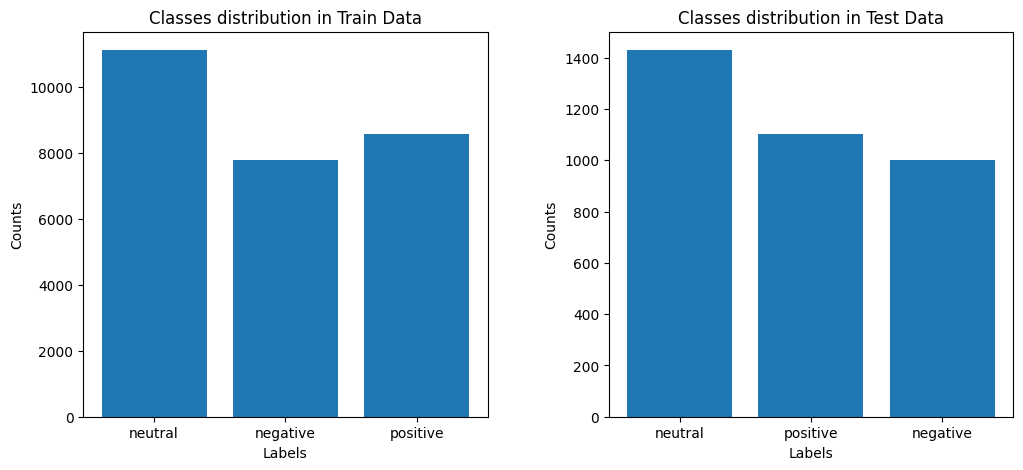

In [51]:
from typing import Counter
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

counter = Counter(train_data['sentiment'])
axs[0].bar(counter.keys(), counter.values())
axs[0].set_title("Classes distribution in Train Data")
axs[0].set_xlabel("Labels")
axs[0].set_ylabel("Counts")

counter = Counter(test_data['sentiment'])
axs[1].bar(counter.keys(), counter.values())
axs[1].set_title("Classes distribution in Test Data")
axs[1].set_xlabel("Labels")
axs[1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

### Map tf-idf feature to dataset

In [52]:
extractor = TfidfVectorizer(ngram_range=(1,3), max_features=50000)
extractor.fit(train_data['processed_text'])
train_tf_idf_feature = extractor.transform(train_data['processed_text']).toarray()
test_tf_idf_feature = extractor.transform(test_data['processed_text']).toarray()

print(f"train tf-idf shape: ({len(train_tf_idf_feature)}, {len(train_tf_idf_feature[0])})")
print(f"test tf-idf shape: ({len(test_tf_idf_feature)}, {len(test_tf_idf_feature[0])})")

def add_tf_idf(example, idx, tf_idf_feature):
    return {'tf_idf': tf_idf_feature[idx]}

train_data = train_data.map(add_tf_idf, with_indices=True, fn_kwargs={'tf_idf_feature': train_tf_idf_feature})
test_data = test_data.map(add_tf_idf, with_indices=True, fn_kwargs={'tf_idf_feature': test_tf_idf_feature})
train_data[0]

train tf-idf shape: (27480, 50000)
test tf-idf shape: (3534, 50000)


Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Kmï¿½)': 652860.0,
 'Density (P/Kmï¿½)': 60,
 '__index_level_0__': 0,
 'processed_text': 'id responded going',
 'label': 1,
 'tf_idf': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
train_data.set_format(type="torch", columns=['tf_idf', 'label'])
test_data.set_format(type="torch", columns=['tf_idf', 'label'])
train_data[0]

device: cpu


{'label': tensor(1), 'tf_idf': tensor([0., 0., 0.,  ..., 0., 0., 0.])}

### Split data into train and valid set

In [54]:
train_dict = Dataset.train_test_split(train_data, test_size=0.2, shuffle=True, seed=2025)
train_data = train_dict['train']
valid_data = train_dict['test']

train_data.shape, valid_data.shape, test_data.shape

((21984, 14), (5496, 14), (3534, 13))

## Step 3: Build Model

- We build a simple Logistic Regression model using neural network block from **torch**.

In [55]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):       # X shape: (N, input_size) => (N, output_size)
        X = self.fc1(X)
        X = self.relu(X)
        X = self.fc2(X)
        X = self.relu(X)
        return self.softmax(X)

## Step 4: Training model

### Define model hyperparameter

In [56]:
learning_rate = 1e-3
batch_size = 32
num_epochs = 20
stop_iter = 3

### Load data into batch

In [57]:
input_size = list(train_data[0]['tf_idf'].size())[0]
hidden_size = 10
output_size = 3

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

len(train_loader), len(valid_loader), len(test_loader)

(687, 172, 111)

In [58]:
def train_fn(model, loader, epoch, optimizer, criteria, show_progress=False):
    model.train()
    epoch_loss = 0
    progress = tqdm(loader, desc=f"Epoch {epoch} training") if show_progress else loader
    for batch in progress:
        input = batch['tf_idf'].to(device)
        label = batch['label'].to(device)
        output = model(input)

        loss = criteria(output, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss
    
    if show_progress:
        print(f"Train loss at epoch {epoch}: {(epoch_loss / len(loader)):.3f}\n---")
    return epoch_loss / len(loader)


def accuracy_eval(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return accuracy_score(labels, predictions)


def f1_score_eval(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return f1_score(labels, predictions, average='weighted')


def evaluate_fn(model, loader, name, criteria, show_progress=False, returned_predictions=False):
    """
    if returned_predictions is True, return the predictions and labels
    else return the accuracy and f1 score
    """
    model.eval()
    valid_loss = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        progress = tqdm(loader, desc=f"Evaluating on {name.lower()} data") if show_progress else loader
        for batch in progress:
            input = batch['tf_idf'].to(device)
            label = batch['label'].to(device)
            output = model(input)

            loss = criteria(output, label)
            valid_loss += loss

            all_outputs.extend(output.detach().cpu().numpy())
            all_labels.extend(label.detach().cpu().numpy())
    
    if returned_predictions:
        return np.array(all_outputs), np.array(all_labels)
        
    acc_score = accuracy_eval(all_outputs, all_labels)
    f1_score = f1_score_eval(all_outputs, all_labels)
    if show_progress:
        print(f"{name} loss: {(valid_loss / len(loader)):.3f} | \
              {name} accuracy: {acc_score:.3f} | {name} F1-score: {f1_score:.3f}\n---\n")
    return acc_score, f1_score

### Model tuning

In [62]:
from hyperparameter_tunning import *
import optuna

n_trials = 10
tuning_epochs = 10

lr_10000_suggestor = IntVariableSuggestion("learning_rate", 1, 100)
hidden_size_suggestor = IntVariableSuggestion("hidden_size", 6, 30)

def objective(trial):
    learning_rate = lr_10000_suggestor.get_suggest(trial) * 1e-4
    hidden_size = hidden_size_suggestor.get_suggest(trial)

    torch.manual_seed(2025)
    model = MLP(input_size, hidden_size, output_size)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criteria = nn.CrossEntropyLoss()

    best_score = 0.5 # set best_score as 0.5
    patience = 3

    for epoch in tqdm(range(tuning_epochs)):
        train_fn(model, train_loader, epoch, optimizer, criteria)
        val_acc, _ = evaluate_fn(model, valid_loader, "Validation", criteria)

        if val_acc > best_score:
            best_score = val_acc
            patience = 3
        else:
            patience -= 1
            if patience <= 0:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return best_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials, timeout=1800)

[I 2025-05-21 16:21:28,211] A new study created in memory with name: no-name-f68d70a8-3dd5-43b4-a0fa-b194f00441c1
 20%|██        | 2/10 [00:52<03:28, 26.03s/it]
[I 2025-05-21 16:22:20,307] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 77, 'hidden_size': 23}. Best is trial 0 with value: 0.5.


Early stopping at epoch 2


 30%|███       | 3/10 [01:01<02:22, 20.34s/it]
[I 2025-05-21 16:23:21,366] Trial 1 finished with value: 0.5041848617176128 and parameters: {'learning_rate': 44, 'hidden_size': 11}. Best is trial 1 with value: 0.5041848617176128.


Early stopping at epoch 3


 20%|██        | 2/10 [00:49<03:18, 24.81s/it]
[I 2025-05-21 16:24:11,025] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 67, 'hidden_size': 20}. Best is trial 1 with value: 0.5041848617176128.


Early stopping at epoch 2


 20%|██        | 2/10 [00:49<03:17, 24.69s/it]
[I 2025-05-21 16:25:00,447] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 76, 'hidden_size': 14}. Best is trial 1 with value: 0.5041848617176128.


Early stopping at epoch 2


 20%|██        | 2/10 [00:49<03:16, 24.53s/it]
[I 2025-05-21 16:25:49,548] Trial 4 finished with value: 0.5 and parameters: {'learning_rate': 70, 'hidden_size': 17}. Best is trial 1 with value: 0.5041848617176128.


Early stopping at epoch 2


 40%|████      | 4/10 [01:32<02:18, 23.12s/it]
[I 2025-05-21 16:27:22,081] Trial 5 finished with value: 0.6570232896652111 and parameters: {'learning_rate': 82, 'hidden_size': 27}. Best is trial 5 with value: 0.6570232896652111.


Early stopping at epoch 4


 20%|██        | 2/10 [00:57<03:49, 28.66s/it]
[I 2025-05-21 16:28:19,452] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 56, 'hidden_size': 28}. Best is trial 5 with value: 0.6570232896652111.


Early stopping at epoch 2


 30%|███       | 3/10 [01:07<02:37, 22.51s/it]
[I 2025-05-21 16:29:27,029] Trial 7 finished with value: 0.6923216885007278 and parameters: {'learning_rate': 18, 'hidden_size': 19}. Best is trial 7 with value: 0.6923216885007278.


Early stopping at epoch 3


 20%|██        | 2/10 [00:49<03:19, 24.89s/it]
[I 2025-05-21 16:30:16,846] Trial 8 finished with value: 0.5 and parameters: {'learning_rate': 74, 'hidden_size': 18}. Best is trial 7 with value: 0.6923216885007278.


Early stopping at epoch 2


 30%|███       | 3/10 [01:14<02:53, 24.82s/it]
[I 2025-05-21 16:31:31,353] Trial 9 finished with value: 0.6934133915574964 and parameters: {'learning_rate': 56, 'hidden_size': 7}. Best is trial 9 with value: 0.6934133915574964.


Early stopping at epoch 3


In [67]:
learning_rate, hidden_size = study.best_params['learning_rate'] * 1e-4, study.best_params['hidden_size']
learning_rate, hidden_size

(0.0056, 7)

In [68]:
torch.manual_seed(2025)
model = MLP(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()
model.to(device)

MLP(
  (fc1): Linear(in_features=50000, out_features=7, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=7, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
# def train_fn(model, loader, epoch):
#     model.train()
#     epoch_loss = 0
#     for batch in tqdm(loader, desc=f"Epoch {epoch} training"):
#         input = batch['tf_idf'].to(device)
#         label = batch['label'].to(device)
#         output = model(input)

#         loss = criteria(output, label)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         epoch_loss += loss
    
#     print(f"Train loss at epoch {epoch}: {(epoch_loss / len(loader)):.3f}\n---")
#     return epoch_loss / len(loader)


# def accuracy_eval(outputs, labels):
#     predictions = np.argmax(outputs, axis=1)
#     return accuracy_score(labels, predictions)


# def f1_score_eval(outputs, labels):
#     predictions = np.argmax(outputs, axis=1)
#     return f1_score(labels, predictions, average='weighted')


# def evaluate_fn(model, loader, name, returned_predictions=False):
#     """
#     if returned_predictions is True, return the predictions and labels
#     else return the accuracy and f1 score
#     """
#     model.eval()
#     valid_loss = 0
#     all_outputs = []
#     all_labels = []

#     with torch.no_grad():
#         for batch in tqdm(loader, desc=f"Evaluating on {name.lower()} data"):
#             input = batch['tf_idf'].to(device)
#             label = batch['label'].to(device)
#             output = model(input)

#             loss = criteria(output, label)
#             valid_loss += loss

#             all_outputs.extend(output.detach().cpu().numpy())
#             all_labels.extend(label.detach().cpu().numpy())
    
#     if returned_predictions:
#         return np.array(all_outputs), np.array(all_labels)
        
#     acc_score = accuracy_eval(all_outputs, all_labels)
#     f1_score = f1_score_eval(all_outputs, all_labels)
#     print(f"{name} loss: {(valid_loss / len(loader)):.3f} | {name} accuracy: {acc_score:.3f} | {name} F1-score: {f1_score:.3f}\n---\n")
#     return acc_score, f1_score

In [69]:
best_score = float("-inf")
patient = 3

train_losses = []
valid_acc_scores = []

for epoch in range(num_epochs):
    train_loss = train_fn(model, train_loader, epoch+1, optimizer, criteria, show_progress=True)
    acc_score, _ = evaluate_fn(model, valid_loader, "Valid", criteria, show_progress=True)

    train_losses.append(train_loss)
    valid_acc_scores.append(acc_score)

    if acc_score > best_score:
        best_score = acc_score
        torch.save(model.state_dict(), "MLP-model.pt")
        patient = 3
        print(f"Save model successfully")
    else:
        patient -= 1
        if patient <= 0:
            print(f"Early stopping at epoch: {epoch}")
            break

Epoch 1 training: 100%|██████████| 687/687 [00:11<00:00, 58.69it/s]


Train loss at epoch 1: 0.955
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 53.16it/s]


Valid loss: 0.862 |               Valid accuracy: 0.693 | Valid F1-score: 0.692
---

Save model successfully


Epoch 2 training: 100%|██████████| 687/687 [00:14<00:00, 46.07it/s]


Train loss at epoch 2: 0.731
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 54.64it/s]


Valid loss: 0.864 |               Valid accuracy: 0.675 | Valid F1-score: 0.675
---



Epoch 3 training: 100%|██████████| 687/687 [00:15<00:00, 45.08it/s]


Train loss at epoch 3: 0.645
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 52.98it/s]


Valid loss: 0.871 |               Valid accuracy: 0.667 | Valid F1-score: 0.667
---



Epoch 4 training: 100%|██████████| 687/687 [00:15<00:00, 45.78it/s]


Train loss at epoch 4: 0.613
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 53.41it/s]

Valid loss: 0.877 |               Valid accuracy: 0.661 | Valid F1-score: 0.661
---

Early stopping at epoch: 3


## Step 4: Model evaluation

### Load best model

In [70]:
model.load_state_dict(torch.load("MLP-model.pt", weights_only=True))

<All keys matched successfully>

### Compute accuracy & F1-Score

In [72]:
test_acc, test_f1 = evaluate_fn(model, test_loader, "Test", criteria, show_progress=True)
print(f"Test accuracy = {test_acc:.4f} | Test f1 = {test_f1:.4f}")

Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 56.94it/s]

Test loss: 0.856 |               Test accuracy: 0.698 | Test F1-score: 0.698
---

Test accuracy = 0.6984 | Test f1 = 0.6984


In [74]:
train_losses = [loss.detach().cpu().numpy() for loss in train_losses]

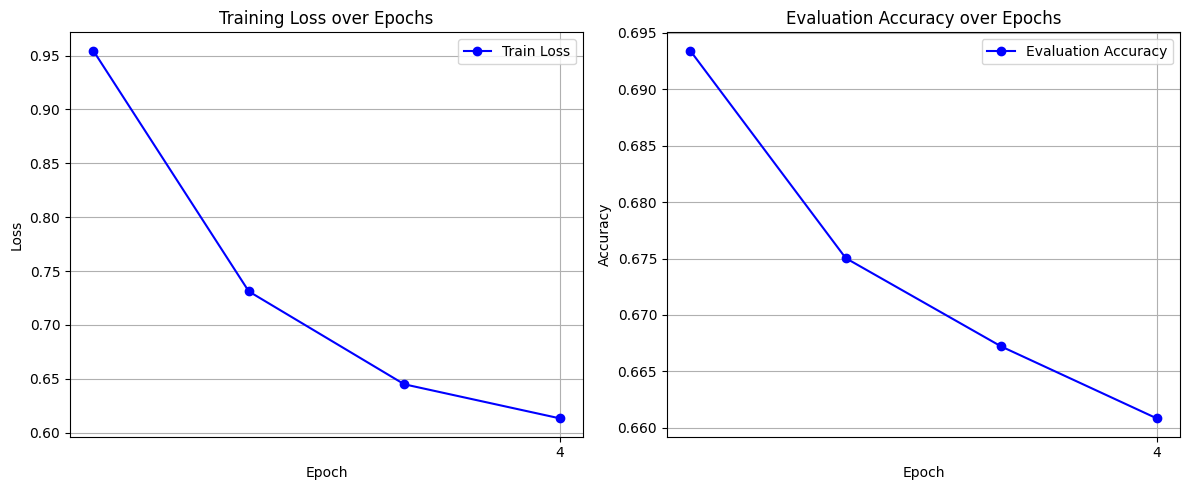

In [75]:
epochs = list(range(1, 21))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
actual_epochs = epochs[:len(train_losses)]

axes[0].plot(actual_epochs, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss over Epochs")
axes[0].grid(True)
axes[0].legend()
axes[0].set_xticks([epoch for epoch in actual_epochs if epoch % 4 == 0])

axes[1].plot(epochs[:len(train_losses)], valid_acc_scores, marker='o', linestyle='-', color='b', label='Evaluation Accuracy')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Evaluation Accuracy over Epochs")
axes[1].grid(True)
axes[1].legend()
axes[1].set_xticks([epoch for epoch in actual_epochs if epoch % 4 == 0])

plt.tight_layout()
plt.show()

### Draw AUC - ROC curves

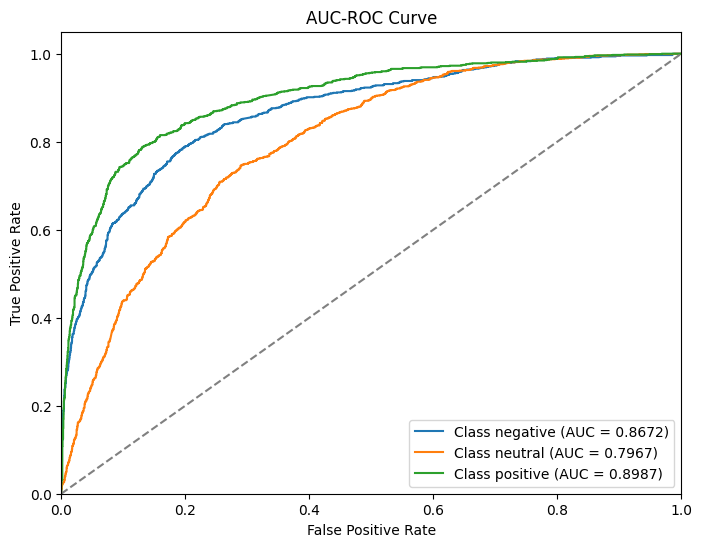

In [77]:
from visualization import plot_roc_auc, plot_confusion_matrix

y_prob, y_true = evaluate_fn(model, test_loader, "Test", criteria, returned_predictions=True)
y_pred = np.argmax(y_prob, axis=1)
y_prob.shape, y_true.shape, y_pred.shape

plot_roc_auc(y_true, y_prob, classes=['negative', 'neutral', 'positive'])

### Plot confusion matrix

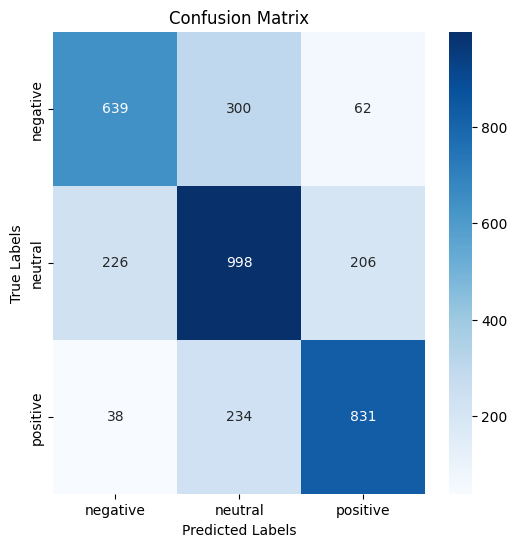

In [78]:
plot_confusion_matrix(y_true, y_pred, class_labels=['negative', 'neutral', 'positive'])